In this script we try to reproduce the results from ".\enso_project.jl\scripts\train_and_validate_esn.ipynb" without performing a TDE on the input data.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


We use the SST Anomaly Index data with following data split: 80% training data | 10% validation data | 10% test data

In [3]:
# read input data into dictionary
data = Dict()

data["train_data_80"] = CSV.read("data/sst_34_data_split_80/train_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["test_data_80"] = CSV.read("data/sst_34_data_split_80/test_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["val_data_80"] = CSV.read("data/sst_34_data_split_80/val_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)

# bring into correct format
data["train_data_80"] = Matrix(transpose(Matrix(data["train_data_80"])))
data["test_data_80"] = Matrix(transpose(Matrix(data["test_data_80"])))
data["val_data_80"] = Matrix(transpose(Matrix(data["val_data_80"])))

data

Dict{Any, Any} with 3 entries:
  "train_data_80" => [0.08 -0.2 … 0.43 0.75]
  "val_data_80"   => [0.63 0.51 … 0.86 0.9]
  "test_data_80"  => [0.67 0.71 … -0.84 -0.69]

### Set hyperparameters

In [4]:
# set up universal parameter options of parameter grid
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.1, 0.12]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [130, 138, 150]
param_grid_80 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_80)

162

### Train network

In [5]:
# network training
esn_80, W_out_80, val_loss_80 = enso_project.cross_validate_esn(data["train_data_80"], data["val_data_80"], param_grid_80)

enso_project.ESNHyperparams(130, 0.8, 0.05, 0.1, 0.0)
Validation loss = 53.01450334986313
enso_project.ESNHyperparams(138, 0.8, 0.05, 0.1, 0.0)
Validation loss = 38.28279812841804
enso_project.ESNHyperparams(130, 1.0, 0.05, 0.1, 0.0)
Validation loss = 32.566272189723286
enso_project.ESNHyperparams(138, 1.0, 0.1, 0.1, 0.0)
Validation loss = 17.531449031286126
enso_project.ESNHyperparams(138, 1.0, 0.1, 0.1, 1.0e-6)
Validation loss = 16.22465136627405


(ESN(1 => 138), OutputLayer successfully trained with output size: 1, 16.22465136627405)

The validation loss is less than in the case with TDE (16.22 vs 30.42)

### Plot prediction

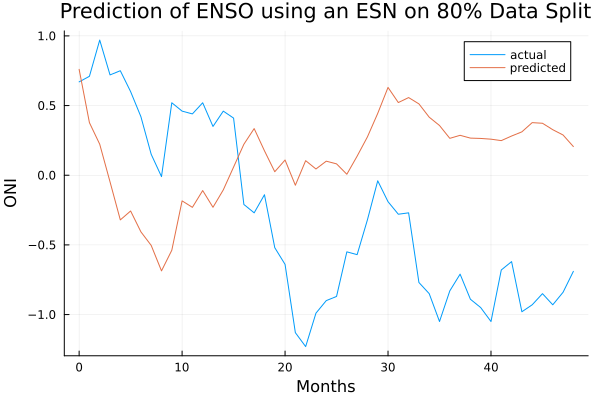

In [6]:
# plot against test data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["test_data_80"], "80% Data Split")

The prediction abilities are worse than with the TDE.

### Plot against train and val data

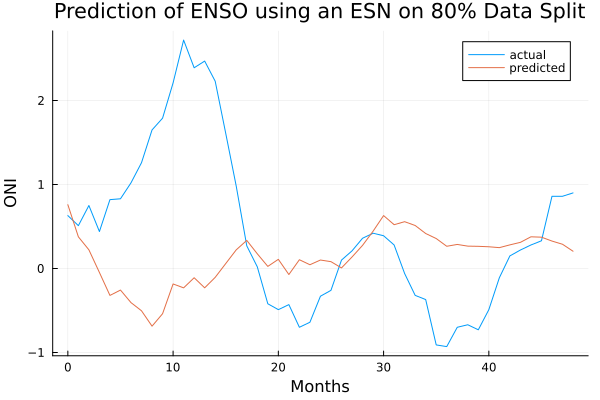

In [13]:
# plot against validation data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["val_data_80"], "80% Data Split")

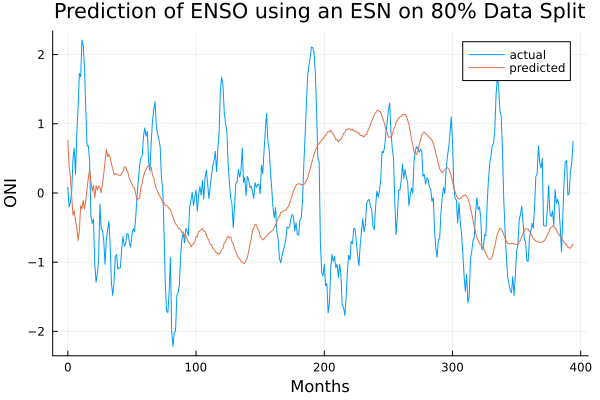

In [14]:
# plot against training data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["train_data_80"], "80% Data Split")

### Evaluation of prediction accuracy

In [15]:
model_prediction = enso_project.esn_eval_pred(esn_80, W_out_80, data["test_data_80"])
model_prediction = transpose(reshape(model_prediction,length(model_prediction),1))

1×49 transpose(::Matrix{Float64}) with eltype Float64:
 0.759788  0.377158  0.222371  -0.0474948  …  0.326681  0.288635  0.205584

In [16]:
#true_data = data["test_data_80"]
true_data = transpose(reshape(data["test_data_80"], length(data["test_data_80"]),1))

1×49 transpose(::Matrix{Float64}) with eltype Float64:
 0.67  0.71  0.97  0.72  0.75  0.6  …  -0.93  -0.85  -0.93  -0.84  -0.69

We plot the absolute difference between forecast and true data. We use an error threshold of 0.1.

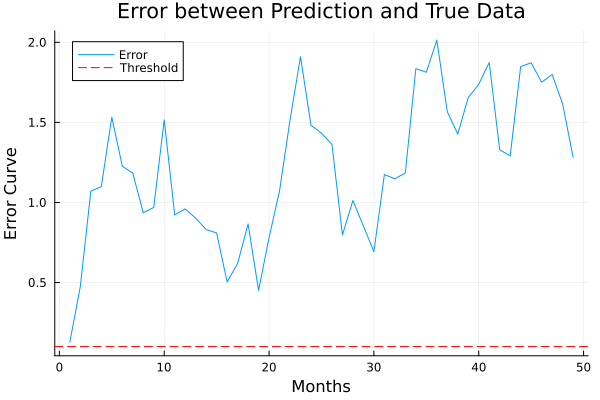

In [17]:
errors = enso_project.forecast_δ_1D(model_prediction, true_data, "abs")
enso_project.plot_error_curve(errors, 0.1)